# Extension of dog-vs-cat classification case(Accuracy:99.1%+)

本jupyter-notebook主要致力于对猫狗分类案例进行进一步的拓展，原始版本采用带EarlyStopping的VGG16网络结构，通过两次随机初始化训练在其中一次训练中获得了91.0%的准确度，本notebook致力于进一步提高案例准确性。

## 主要思路

- 采用更深的架构(InceptionResNetV2)
- 采用预训练权重进行迁移学习(Pretrained on 'imagenet')
- 进行数据增强(scale, transform, flip .etc)

## 1. Prepare

In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 51kB 55.6MB/s eta 0:00:01
     |████████████████████████████████| 317kB 62.0MB/s eta 0:00:01   | 204kB 62.0MB/s eta 0:00:01
     |████████████████████████████████| 51kB 64.1MB/s eta 0:00:01
  Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
  Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0


## 2. Import Lib

In [63]:
import shutil
import math
import sys

import os, cv2, random
import numpy as np

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras import backend as K
K.set_image_data_format('channels_last') # 数据格式data_format设置为 NHWC

## 3. Download Data

In [3]:
from modelarts.session import Session
session = Session()

if not os.path.exists('./data'):
    session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

## 4. Reconstruct Data

In [8]:
!mkdir ./data/cat
!mkdir ./data/dog

In [18]:
cat_directory_name = './data/cat'
dog_directory_name = './data/dog'

for f in os.listdir('./data'):
    if f.endswith('.jpg'):
        if 'cat' in f:
            path = os.path.join('./data', f)
            shutil.copy(path, cat_directory_name)
        if 'dog' in f:
            path = os.path.join('./data', f)
            shutil.copy(path, dog_directory_name)

In [43]:
os.listdir('./data')

['dog', 'cat']

## 5. Split dataset

将数据分为训练集、验证集、测试集，将文件结构重新组织。

In [44]:
#Train and Test Set Variables
train_val_test_ratio = (.7,.1,.2) # 70/10/20 Data Split
test_folder = './data/test/'
train_folder = './data/train/'
val_folder = './data/val/'

file_names = ['cat','dog']

#Remove Existing Folders if they exist
for folder in [test_folder, train_folder, val_folder]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)

#Remake Category Folders in both Train and Test Folders
for category in file_names:
    os.makedirs(test_folder + category)
    os.makedirs(train_folder + category)
    os.makedirs(val_folder + category)

#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(file_names):
    file_list = os.listdir('./data' + '/' + category)
    
    train_ratio = math.floor(len(file_list) * train_val_test_ratio[0])
    val_ratio = math.floor(len(file_list) * train_val_test_ratio[1])
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    test_list = file_list[train_ratio + val_ratio:]
    
    for i, file in enumerate(train_list):
        shutil.copy('./data' + '/' + category + '/' + file, train_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy('./data' + '/' + category + '/' + file, val_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    for i, file in enumerate(test_list):
        shutil.copy('./data' + '/' + category + '/' + file, test_folder + '/' + category + '/' + file)
    sys.stdout.write('Moving %s test images to category folder %s' % (len(test_list), category))
    sys.stdout.write('\n')
    
print("Done.")  

Moving 8750 train images to category folder cat
Moving 1250 validation images to category folder cat
Moving 2500 test images to category folder cat
Moving 8750 train images to category folder dog
Moving 1250 validation images to category folder dog
Moving 2500 test images to category folder dog
Done.


## 6. Build DataGenerator

构造训练数据、测试数据、验证数据生成器，使数据在训练、验证和测试过程中分批输入网络。

同时对于训练数据进行了数据增强。

In [49]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

In [58]:
WIDTH=299
HEIGHT=299
CHANNELS=3
BATCH_SIZE=16

In [68]:
print("\nTrain Data Set")
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.3, 
    vertical_flip=True,
    horizontal_flip=True, 
    fill_mode="nearest")
train_flow = train_generator.flow_from_directory(
    train_folder,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

print("\nValidation Data Set")
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_flow = val_generator.flow_from_directory(
    val_folder,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)

#Test DataSet Generator with Augmentation
print("\nTest Data Set")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    test_folder,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Train Data Set
Found 17500 images belonging to 2 classes.

Validation Data Set
Found 2500 images belonging to 2 classes.

Test Data Set
Found 5000 images belonging to 2 classes.


## 7. Model Construct

模型为基于InceptionResNetV2的预训练模型，去除top layer（分类层），在这一基础上冻结预训练参数，并在此基础上增加一个512 hidden unit的全连接层和一个2 hidden unit的分类层。

In [60]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT, CHANNELS))

In [61]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [64]:
for layer in base_model.layers:
    layer.trainable = False

model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
_______________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_382 (BatchN (None, 8, 8, 256)    768         conv2d_382[0][0]                 
__________________________________________________________________________________________________
activation_379 (Activation)     (None, 8, 8, 192)    0           batch_normalization_379[0][0]    
__________________________________________________________________________________________________
activation_382 (Activation)     (None, 8, 8, 256)    0           batch_normalization_382[0][0]    
__________________________________________________________________________________________________
block8_4_mixed (Concatenate)    (None, 8, 8, 448)    0           activation_379[0][0]             
                                                                 activation_382[0][0]             
__________________________________________________________________________________________________
block8_4_c

In [65]:
import keras 
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## 8. Train Model

In [67]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_acc', baseline=0.9, patience=15, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./ckpt_InceptionResNetV2_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=3, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [71]:
history = model.fit_generator(train_flow, 
                              epochs=5, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                            callbacks=callbacks)

Epoch 1/5
1094/1094 [==============================] - 370s 338ms/step - loss: 0.1950 - acc: 0.9211 - val_loss: 0.0334 - val_acc: 0.9916

Epoch 00001: val_acc improved from -inf to 0.99160, saving model to ./ckpt_InceptionResNetV2_dog_and_cat.h5
Epoch 2/5
1094/1094 [==============================] - 361s 330ms/step - loss: 0.1883 - acc: 0.9222 - val_loss: 0.0428 - val_acc: 0.9896

Epoch 00002: val_acc did not improve from 0.99160
Epoch 3/5
1094/1094 [==============================] - 360s 329ms/step - loss: 0.1834 - acc: 0.9230 - val_loss: 0.0487 - val_acc: 0.9872

Epoch 00003: val_acc did not improve from 0.99160
Epoch 4/5
1094/1094 [==============================] - 358s 327ms/step - loss: 0.1790 - acc: 0.9270 - val_loss: 0.0339 - val_acc: 0.9928

Epoch 00004: val_acc improved from 0.99160 to 0.99280, saving model to ./ckpt_InceptionResNetV2_dog_and_cat.h5
Epoch 5/5
1094/1094 [==============================] - 357s 326ms/step - loss: 0.1743 - acc: 0.9278 - val_loss: 0.0394 - val_acc:

In [72]:
OUTPUT = 'output'

if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)

model.save(os.path.join(OUTPUT, 'model_InceptionResNetV2.h5'))

## 9. Visualization

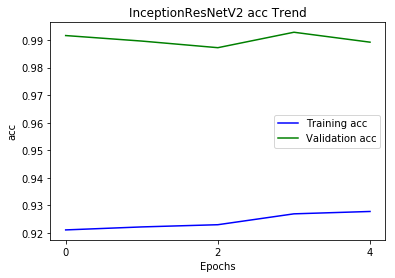

In [74]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('InceptionResNetV2 acc Trend')
plt.plot(acc, 'blue', label='Training acc')
plt.plot(val_acc, 'green', label='Validation acc')
plt.xticks(range(0, 5)[0::2])
plt.legend()
plt.show()

## 10. Evaluation

In [75]:
loss, acc = model.evaluate_generator(
    test_flow,
    verbose = True,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))

313/313 [==============================] - 38s 122ms/step


In [76]:
print("Loss: ", loss)
print("Acc: ", acc)

Loss:  0.03786078913548263
Acc:  0.9914


In [78]:
print('最终测试集上得到的猫狗识别模型的准确度是：%f' % acc)

最终测试集上得到的猫狗识别模型的准确度是：0.991400


# 总结

本次拓展主要做了以下几方面的改进：
- 使用ImageDataGenerator:
    - 所有数据不直接写入内存，分批读入降低内存负担
    - 加强了数据增强，对于训练数据采用了以下增强：旋转、平移、放缩、翻转
- 网络架构上改为InceptionResNetV2，增加了模型容量
- 采用ImageNet预训练权重加速训练
最终效果：
准确率90.1%-->99.1%(应该还能提高没有计算资源了。。。)